# Домашняя работа 1

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
random.seed(239)

## Подготовка данных

Будем использовать датасет Palmer Penguins ля предсказания вида пингвина (признак `species`)

Признаки, которые есть в датасете:
- `species` − вид пингвина, наш целевой признак
- `island` − остров, на котором был замечен пингвин
- `bill_length_mm` − длина клюва в мм
- `bill_depth_mm` − ширина клюва в мм
- `flipper_length_mm` − длина крыльев в мм
- `body_mass_g` − вес в граммах
- `sex` − пол
- `year` − год, когда запись о пингвине была внесена в датасет

In [3]:
df = pd.read_csv("hf://datasets/SIH/palmer-penguins/penguins.csv")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Проверим данные на наличие пропусков: они есть в небольшом количестве в некоторых столбцах.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


Изуим некоторые статистические характеристики числовых столбцов

Видим, что среднее значение и медиана каждого столбца достаточно близки. Это может говорить о том, что в данных нет выбросов и распределение значений не скошено. На это же указывают значения `min` и `max`, которые тоже не сильно далеки от 25 и 75 перцентилей соответственно

In [5]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


Теперь посмотрим поближе на категориальные признаки

Наш целевой признак `species` принимает одно из трех значений, причем распределены они не очень равномерно

In [6]:
df['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

Похожая ситуация с островом, на котором сделана запись

In [7]:
df['island'].value_counts()

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

А вот пол распределен практически идеально поровну

In [8]:
df['sex'].value_counts()

sex
male      168
female    165
Name: count, dtype: int64

Изучим данные подробнее при помощи графиков

Построим гистограмму со значениями `flipper_length_mm`. Видим, что на первый взгляд данные разбросаны без явных закономерностей

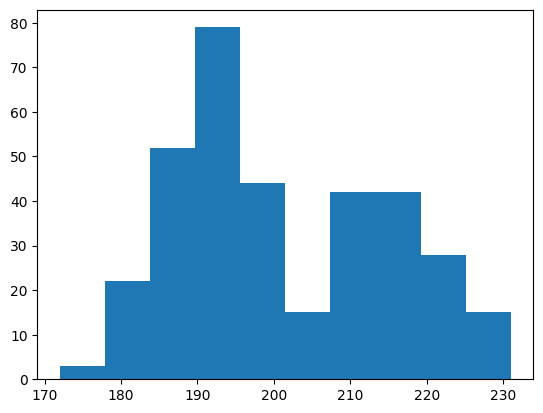

In [9]:
plt.hist(df['flipper_length_mm'])
plt.show()

Построим отдельные графики для каждого из трех видов и увидим достаточно сильную связь между длиной крыльев и видом пингвина. На общем графике эти значения друг на друга накладывалсь и эта закономерность была незаметна

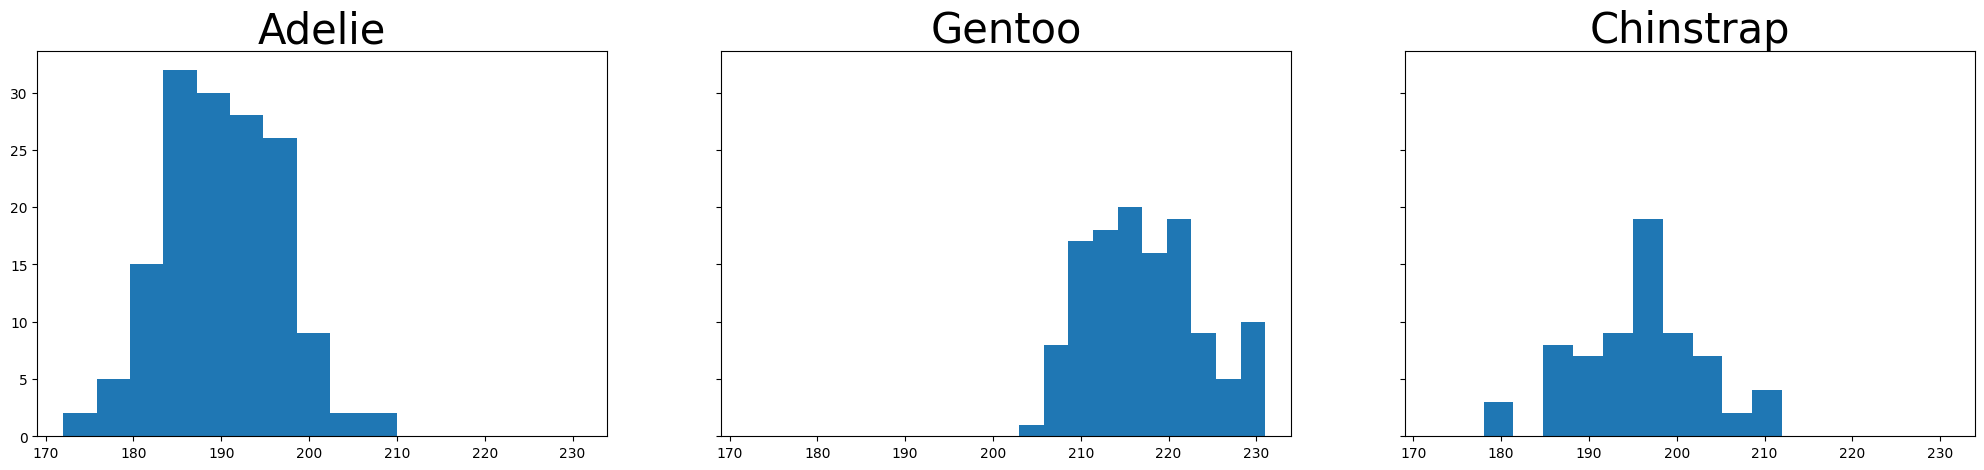

In [10]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(25, 5))
fig.set_label('flipper_length_mm across species')

for i, s in enumerate(df['species'].unique()):
    axs[i].hist(df[df['species'] == s]['flipper_length_mm'])
    axs[i].set_title(s, fontsize=30)
    
plt.show()

### Посмотрим, есть ли связь между измерениями клюва (длина и ширина) и видом пингвина

Точки разбились на три отчетливых кластера, что говорит нам о том, что между этими параметрами есть достаточно сильная связь

<Axes: xlabel='bill_depth_mm', ylabel='bill_length_mm'>

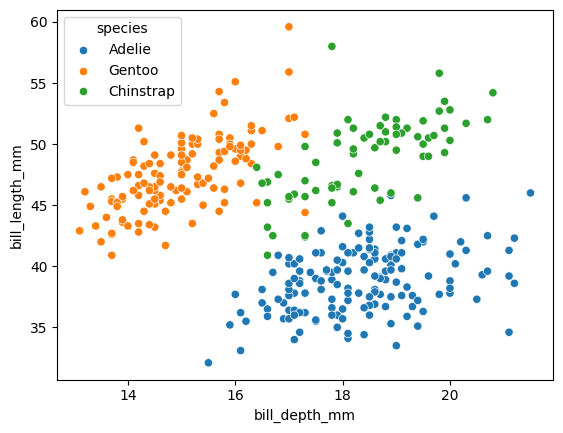

In [11]:
sns.scatterplot(x=df['bill_depth_mm'], y=df['bill_length_mm'], hue=df['species'])

Полезно будет узнать, равномерно ли распределены значения пола внутри каждого вида

In [12]:
df.groupby('species')['sex'].value_counts()

species    sex   
Adelie     female    73
           male      73
Chinstrap  female    34
           male      34
Gentoo     male      61
           female    58
Name: count, dtype: int64

Видим, что внури видов данные собраны равномерно для особей мужского и женского пола

Вернемся к пропускам в данных и решим, что будем с ними делать

In [13]:
df.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

Наш датасет небольшой, в нем всего 344 записи, поэтому (и потому, что пропусков не так много) мы не будем избавляться от столбцов/строк с пропусками, а заполним их.

Для числовых значений воспользуемся медианой

In [14]:
df['bill_length_mm'].fillna(df['bill_length_mm'].median(), inplace=True)
df['bill_depth_mm'].fillna(df['bill_depth_mm'].median(), inplace=True)
df['flipper_length_mm'].fillna(df['flipper_length_mm'].median(), inplace=True)
df['body_mass_g'].fillna(df['body_mass_g'].median(), inplace=True)

Поскольку для категориального признака, которым является пол, недоступны медиана и среднее, из статистических признаков у нас остается только мода. Но ранее мы видели, что пол распределен практически поровну. В этом столбце пропущено 11 значений, и если мы заменим их все модой, это достаточно сильно повлияет на равномерность распределения (помним, что у нас всего 344 записи)

Поэтому воспользуемся случайной импутацией (заменим пропуски на случайные значенияя из нашего столбца)

In [15]:
df.loc[df['sex'].isna(), 'sex'] = df['sex'].dropna().sample(
  df['sex'].isna().sum(),
  replace=True
).values

Мы заполнили все пропуски в данных и сохранили равномерность распределения для пола

In [16]:
df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
year                 0
dtype: int64

In [17]:
df.groupby('species')['sex'].value_counts()

species    sex   
Adelie     male      77
           female    75
Chinstrap  female    34
           male      34
Gentoo     male      66
           female    58
Name: count, dtype: int64

Теперь закодируем категориальные переменные

In [18]:
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

In [19]:
df = pd.get_dummies(df, columns=['island'], drop_first=True, dtype=np.int64)

Проверим данные на мультиколлинеарность

In [20]:
df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,island_Dream,island_Torgersen
0,Adelie,39.10,18.7,181.0,3750.0,0,2007,0,1
1,Adelie,39.50,17.4,186.0,3800.0,1,2007,0,1
2,Adelie,40.30,18.0,195.0,3250.0,1,2007,0,1
3,Adelie,44.45,17.3,197.0,4050.0,0,2007,0,1
4,Adelie,36.70,19.3,193.0,3450.0,1,2007,0,1
...,...,...,...,...,...,...,...,...,...
339,Chinstrap,55.80,19.8,207.0,4000.0,0,2009,1,0
340,Chinstrap,43.50,18.1,202.0,3400.0,1,2009,1,0
341,Chinstrap,49.60,18.2,193.0,3775.0,0,2009,1,0
342,Chinstrap,50.80,19.0,210.0,4100.0,0,2009,1,0


In [21]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43156001218774975, 0.6160490836499025, 0.6735874169971766),
 (0.611122882611058, 0.7333644584921324, 0.7720145556336929),
 (0.7906857530343663, 0.8506798333343624, 0.8704416942702093),
 (0.95, 0.95, 0.95),
 (0.9282549678814984, 0.7863704363662967, 0.7963965173228867),
 (0.9022582584936525, 0.6005186021022944, 0.622400049291663),
 (0.8762615491058064, 0.4146667678382919, 0.44840358126043944),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

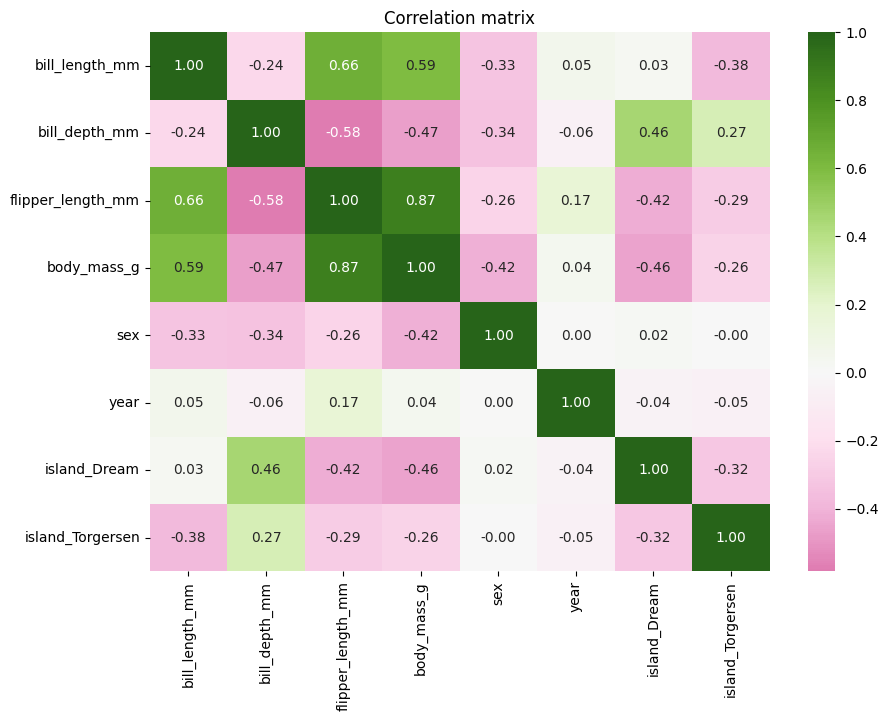

In [22]:
# numeric_cols = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 7))
sns.heatmap(df.drop('species', axis=1).corr(), annot=True, center=0, cmap='PiYG', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

Видим сильную корреляцию между `body_mass_g` и `flipper_length_mm` (0.87) и между `flipper_length_mm` и `bill_length_mm` (0.66). Это достаточно логично: чем больше пингвин, тем больше (длиннее) у него крылья и клюв. Избавимся от признака `flipper_length_mm`

In [23]:
df.drop('flipper_length_mm', axis=1, inplace=True)

In [24]:
le = LabelEncoder()
df.insert(1, 'species_label', value=le.fit_transform(df['species']))

## Логистическая регрессия

Построим и обучим модель логистической регрессии

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['species_label', 'species'], axis=1),
    df['species_label'],
    random_state=1,
    test_size=0.3,
)

In [26]:
def print_metrics(split_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"{split_name}: accuracy={acc:.3f}, macro-F1={f1m:.3f}")

In [27]:
logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=0.1,
        max_iter=100,
        multi_class="multinomial",
        random_state=1,
        fit_intercept=True,
    )),
])

logreg_clf.fit(X_train, y_train)

y_pred_logreg = logreg_clf.predict(X_test)

Метрики accuracy и F1 у модели вышли достаточно высокими, и часто такое может указывать на ошибки в подготовке данных (например, наличие линейной зависимости между признаками). Однако в нашем случае данные действительно достаточно хорошо бьются на кластеры (мы видели это на этапе построения графиков), а размер выборки достаточно небольшой

In [28]:
print_metrics("Logistic regression", y_test,  y_pred_logreg)

Logistic regression: accuracy=0.990, macro-F1=0.988


In [29]:
y_test.shape

(104,)

Модель ошиблась в предсказании всего для одной записи из 104, предсказав пингвина вида Chinstrap как Adelie

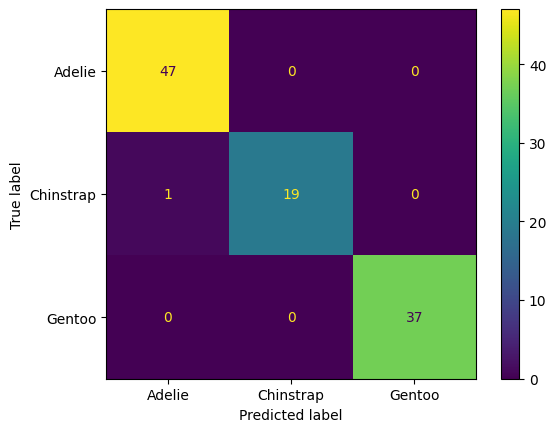

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, display_labels=le.classes_)

## Decision Tree Classifier

Построим и обучим модель Decision Tree Classifier

In [31]:
dt = Pipeline([
    ("scaler", StandardScaler()),
    ("decision_tree", DecisionTreeClassifier(
        max_depth=2,
        random_state=1,  
    )),
])


dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

У Decision Tree метрики accuracy и F1 вышли чуть ниже, чем у логистической регрессии, но все равно остаются достаточно высокими

In [32]:
print_metrics("Decision Tree Classifier", y_test,  y_pred_dt)

Decision Tree Classifier: accuracy=0.962, macro-F1=0.964


На матрице ошибок видим, что помимо ошибочной классификации одного пингвина Chinstrap как Adelie (ошибка, которую совершила и модель логистической регресии), эта модель приняла 3 пингвинов Adelie за Gentoo

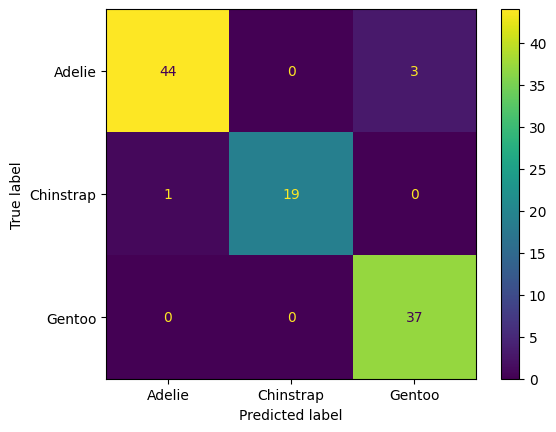

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels=le.classes_)

## Анализ

Возможно, модели ошиблись на одном и том же пингвине Chinstrap. Проверим, так ли это

In [35]:
y_test[y_pred_logreg != y_test]

306    1
Name: species_label, dtype: int64

In [36]:
y_test[y_pred_dt != y_test]

306    1
131    0
111    0
73     0
Name: species_label, dtype: int64

Действительно видим, что обе модели предсказали запись 306 неверно. Посмотрим, что это за пингвин

In [37]:
le.classes_[y_test.loc[306]]

'Chinstrap'

In [38]:
X_test.loc[306]

bill_length_mm        40.9
bill_depth_mm         16.6
body_mass_g         3200.0
sex                    1.0
year                2008.0
island_Dream           1.0
island_Torgersen       0.0
Name: 306, dtype: float64

Снова построим график с размерами клюва и закодируем виды цветами. Отдельно отметим нашего пингвина звездой. Видно, что он находится достаточно близко к кластеру вида Adelie (модель как раз приняла его за этот вид), хотя на самом деле он относится к Chinstrap

<Axes: xlabel='bill_depth_mm', ylabel='bill_length_mm'>

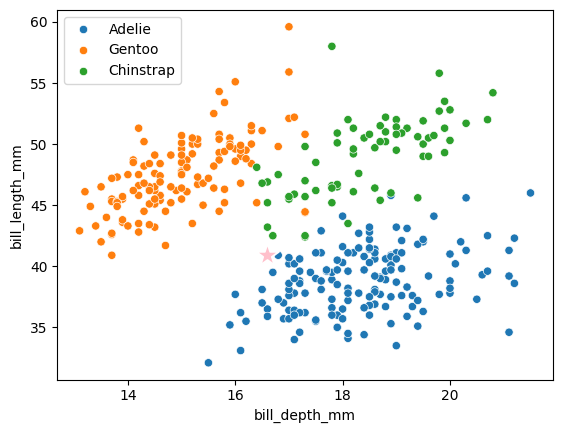

In [39]:
sns.scatterplot(x=df.drop(306)['bill_depth_mm'], y=df.drop(306)['bill_length_mm'], hue=df['species'])
sns.scatterplot(x=[X_test.loc[306]['bill_depth_mm']], y=[X_test.loc[306]['bill_length_mm']], marker='*', color='pink', s=300)

Конечно, это не единственный пингвин, выбивающийся из своего кластера по размеру клюва, но обе модели ошиблись именно на нем. Можем сделать вывод, что остальные его признаки тоже больше похожи на типичные для других видов

С другой стороны, в решении задач машинного обучения у нас нет цели добиться 100% точности. Такие высокие показатели в этой задаче скорее являются следствием малого размера датасета и сильных различий у признаков каждого из видов пингвинов. Такой случай можно отнести к исключениям, и в большинстве реальных задач нет необходимости прицельно разбирать каждую из ошибок модели

## Снижение количества признаков

Теперь попробуем посмотреть, в какую сторону изменятся (и изменятся ли) показатели моделей, если мы уберем признаки `island` и `sex`

In [40]:
df.drop('sex', axis=1, inplace=True)
df.drop('island_Dream', axis=1, inplace=True)
df.drop('island_Torgersen', axis=1, inplace=True)

In [41]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    df.drop(['species_label', 'species'], axis=1),
    df['species_label'],
    random_state=1,
    test_size=0.3,
)

In [42]:
logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=0.1,
        max_iter=100,
        multi_class="multinomial",
        random_state=1,
        fit_intercept=True,
    )),
])

logreg_clf.fit(X_train_s, y_train_s)

y_pred_logreg_s = logreg_clf.predict(X_test_s)

Видим, что метрики незначительно ухудшились, а матрица ошибок показывает на одну ошибку больше

In [43]:
print_metrics("Logistic regression\t\t\t", y_test,  y_pred_logreg)
print_metrics("Logistic regression on smaller dataset\t", y_test_s,  y_pred_logreg_s)

Logistic regression			: accuracy=0.990, macro-F1=0.988
Logistic regression on smaller dataset	: accuracy=0.981, macro-F1=0.976


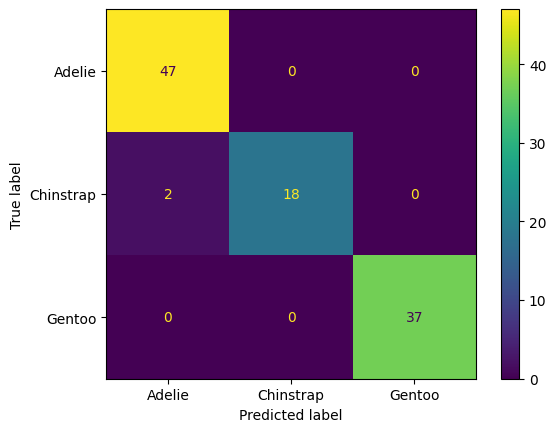

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test_s, y_pred_logreg_s, display_labels=le.classes_)

Теперь проделаем то же самое для Decision Tree Classifier

In [45]:
dt = Pipeline([
    ("scaler", StandardScaler()),
    ("decision_tree", DecisionTreeClassifier(
        max_depth=2,
        random_state=1,  
    )),
])


dt.fit(X_train_s, y_train_s)

y_pred_dt_s = dt.predict(X_test_s)

Для Decision Tree видим аналогичные незначительные ухудшения

In [48]:
print_metrics("Decision Tree Classifier\t\t\t", y_test,  y_pred_dt)
print_metrics("Decision Tree Classifier on smaller dataset\t", y_test_s,  y_pred_dt_s)

Decision Tree Classifier			: accuracy=0.962, macro-F1=0.964
Decision Tree Classifier on smaller dataset	: accuracy=0.923, macro-F1=0.908


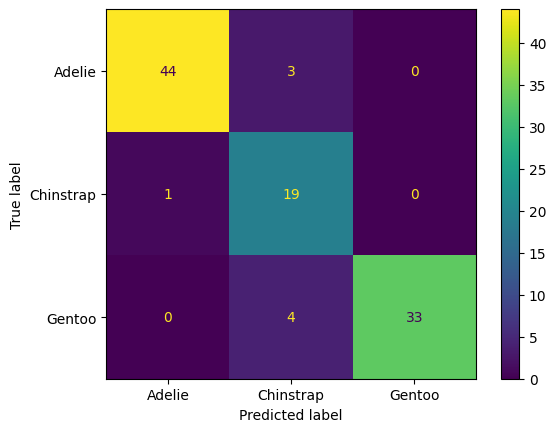

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test_s, y_pred_dt_s, display_labels=le.classes_)

## Итоги

Можем сделать вывод, что обе модели в некоторой (но достаточно небольшой степени) опираются на признаки `sex` и `island`. Соответственно, наиболее значимыми признаками можем считать физические характеристики пингвинов, такие как вес и размеры клюва (на это же указывает тот факт, что пингвин с клювом, больше похожим на другой вид, был классифицирован неверно)

Обе модели, построенные в этой работе, справились с задачей достаточно хорошо (Logistic regression 0.990, Decision tree 0.962) и не сильно ухудшились от уменьшения количества признаков. Было бы полезно проверить обе модели на датасете большего размера: возможно, одна или обе переобучились на закономерностях этого датасета, которые не выявились бы на данных большего объема

На таком небольшом количестве данных сложно заметить закономерности в ошибках, но интересно заметить, что при уменьшении количества признаков Decision tree стала намного чаще ошибочно классифицировать виды как Chinstrap